<h1>Sentiment analysis aided DAC</h1>

In [1]:
#Libraries
import re
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
df = pd.read_csv("test_SA.csv")
def processed_data(data):
    data=data.drop(columns=["Unnamed: 0"])
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [3]:
full_data = pd.read_csv('full_SA.csv')
MAX_PADDING = 99
def x_value(data):
    tokenizer = Tokenizer(num_words = 16000, split=" ")
    tokenizer.fit_on_texts(full_data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)

    return x

In [4]:
train_data = pd.read_csv('train_SA.csv')
train_data,y_train = processed_data(train_data)
x_train = x_value(train_data)
train_sen = np.array(train_data['SA'])
train_sen = train_sen.reshape(75066, 1)
x_train = np.concatenate((x_train, train_sen), axis=1)



val_data = pd.read_csv('val_SA.csv')
val_data,y_val = processed_data(val_data)
x_val = x_value(val_data)
val_sen = np.array(val_data['SA'])
val_sen = val_sen.reshape(16432, 1)
x_val = np.concatenate((x_val, val_sen), axis=1)

test_data = pd.read_csv('test_SA.csv')
test_data,y_test = processed_data(test_data)
x_test = x_value(test_data)
test_sen = np.array(test_data['SA'])
test_sen = test_sen.reshape(16701, 1)
x_test = np.concatenate((x_test, test_sen), axis=1)

In [5]:
MAX_LENGTH_PER_SENTENCE=100
units = 128
drop = 0.2
encoder_input = keras.Input(shape=(MAX_LENGTH_PER_SENTENCE))

In [6]:
def module(encoder_input):
    x =layers.Embedding(input_dim=16000, 
                        output_dim=256, 
                        input_length=x_train.shape[1])(encoder_input)
                                
    activations = Bidirectional(LSTM(units, 
                                    dropout=0.3, 
                                    recurrent_dropout=0.2,
                                    return_sequences=True))(x)

    attention = Dense(1, activation='tanh')(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units*2)(attention)
    attention = Permute((2, 1))(attention)

    sent_representation = Multiply()([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), 
                                output_shape=(units*2,))(sent_representation)

    reshape = Reshape((-1, 1, 256))(sent_representation)
    flat = TimeDistributed(Flatten())(reshape)
    dense_1 = Dense(5, activation='relu')(flat)
    dropout_1 = Dropout(drop)(dense_1)


    #conversation level
    biLSTM1 = Bidirectional(LSTM(5, return_sequences='true'))(dropout_1)
    biLSTM2 = Bidirectional(LSTM(5))(biLSTM1)

    dense_2 = Dense(5, activation='relu')(biLSTM2)
    dropout_2 = Dropout(drop)(dense_2)


    dropout_flat = Flatten()(dropout_1)
    merged_2 = concatenate([dropout_flat, dropout_2])
    dense_3 = Dense(units=5, input_shape=(1,))(merged_2)
    output = Activation('softmax')(dense_3)

    return output

In [7]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=1, 
                                               verbose=1)

In [8]:
model = keras.Model(inputs=[encoder_input], outputs=[module(encoder_input)])

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks = early_stopping,
          validation_data=(x_val, y_val))

Epoch 1/100
2346/2346 [==============================] - 1220s 517ms/step - loss: 0.9804 - accuracy: 0.6480 - val_loss: 0.8282 - val_accuracy: 0.6667
Epoch 2/100
2346/2346 [==============================] - 1236s 527ms/step - loss: 0.7361 - accuracy: 0.7463 - val_loss: 0.6899 - val_accuracy: 0.7629
Epoch 3/100
2346/2346 [==============================] - 1235s 526ms/step - loss: 0.6318 - accuracy: 0.7797 - val_loss: 0.6394 - val_accuracy: 0.7746
Epoch 4/100
2346/2346 [==============================] - 1238s 528ms/step - loss: 0.5858 - accuracy: 0.7952 - val_loss: 0.6441 - val_accuracy: 0.7757
Epoch 5/100
2346/2346 [==============================] - 1252s 534ms/step - loss: 0.5566 - accuracy: 0.8059 - val_loss: 0.6289 - val_accuracy: 0.7774
Epoch 6/100
2346/2346 [==============================] - 1244s 530ms/step - loss: 0.5371 - accuracy: 0.8129 - val_loss: 0.6465 - val_accuracy: 0.7790
Epoch 7/100
2346/2346 [==============================] - 1243s 530ms/step - loss: 0.5164 - accuracy:

In [12]:
model.save('SAVED_MODEL.h5')

C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [13]:
saved_model = load_model('SAVED_MODEL.h5')

In [14]:
saved_model.evaluate(x_test,y_test)

522/522 [==============================] - 43s 80ms/step - loss: 0.7965 - accuracy: 0.7581


[0.7965343594551086, 0.758098304271698]

In [15]:
y_pred = saved_model.predict(x_test)

In [16]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [17]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 879    1   23    0 1249]
 [  35 1392  164   76  672]
 [  33   51 1107    1  216]
 [  26   95    0  466  644]
 [  79  405   30  240 8817]]


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

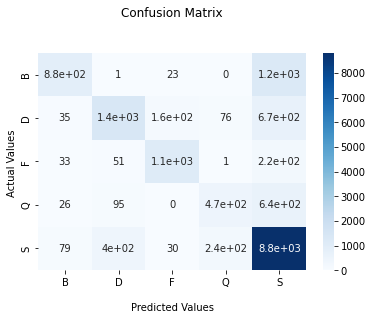

F1 score(macro) 0.6609734673939238
F1 score(micro) 0.75809831746602


In [19]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['B','D','F','Q','S'])
ax.yaxis.set_ticklabels(['B','D','F','Q','S'])

## Display the visualization of the Confusion Matrix.
plt.show()

from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))